**LIBRARIES**

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

**DATALOADERS**

In [2]:
transform = transforms.Compose([
    #transforms.Resize((28,28)),
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,))
])


In [3]:
data_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
print(len(data_test))

100%|██████████| 9912422/9912422 [00:03<00:00, 2821739.96it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 3365067.33it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3648553.43it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

10000


In [4]:
BATCH = 50
train_dataloader = DataLoader(data_train, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=BATCH, shuffle=True)
print(len(train_dataloader))
print(len(test_dataloader))

1200
200


**DATASET SAMPLING**

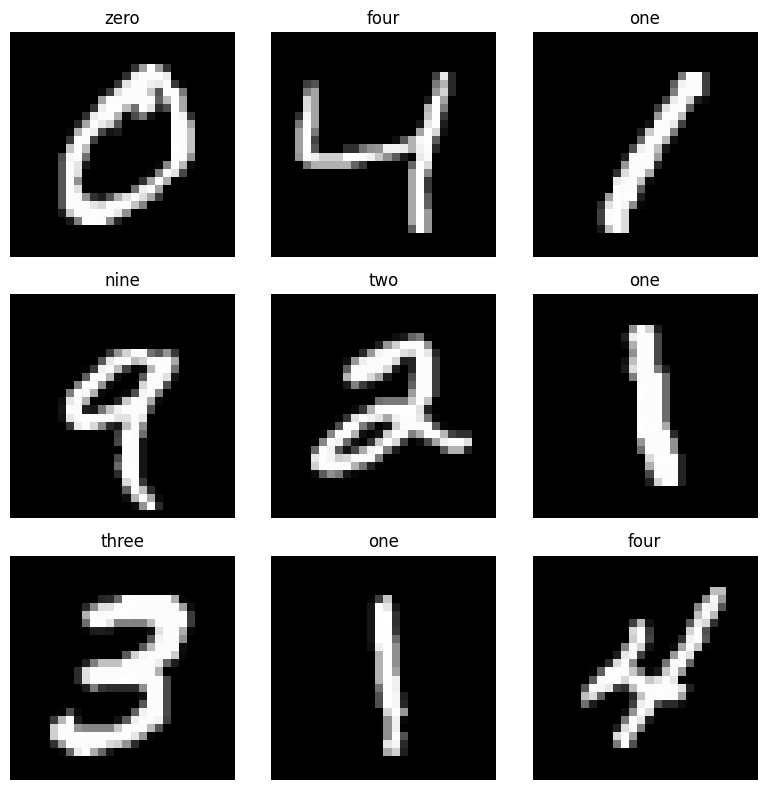

In [5]:
labels_map = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}

figure = plt.figure(figsize=(8, 8))
for i in range(1, 10):
    img, label = data_train[i]
    plt.subplot(3, 3, i)
    plt.imshow(img[0], cmap="gray")  # 
    plt.title(labels_map[label])
    plt.axis("off")

plt.tight_layout()
plt.show()

**MODEL DEFINITION**
# **LeNET**

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.c2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 84)
        self.fc2 = nn.Linear(84, 10)
        
        self.act = nn.Tanh()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.loss_criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, op):
        op = self.act(self.c1(op))
        #print("after 1st conv:",op.shape)
        op = self.pool(op)
        #print("after 1st pooling:",op.shape)
        op = self.act(self.c2(op))
        #print("before pooling:",op.shape)
        op = self.pool(op)
        
        #print("after pooling:",op.shape)
        op = op.view(op.size(0), -1)
        #print("after view", op.shape)
        op = self.act(self.fc1(op))
        op = self.act(self.fc2(op))
        return op
    
    def fit(self, X, Y):
        '''
        Fit function for training on dataset.
        
        Inputs:
        X - ground truth images
        Y - ground truth labels
        y_pred - predicted labels 
        
        Returns the loss calculated.
        '''
        self.optimizer.zero_grad()
        y_pred = self.forward(X)
        loss = self.loss_criterion(y_pred, Y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def predict(self, X):
        '''
        Prediction function. Uses forward function without gradients (no backpropagation).
        
        Inputs:
        X - ground truth images
        
        Returns highest probability scores.
        '''
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=1)
        
    def validate(self, X, Y):
        correct = 0
        y_pred = self.predict(X)
        correct += (Y==y_pred).sum()
        return correct
    

In [7]:
model = NN()
print(model)
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# defining the loss function
loss_criterion = nn.CrossEntropyLoss()

NN(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (c2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (act): Tanh()
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (loss_criterion): CrossEntropyLoss()
)


**TRAINING** 

In [8]:
num_epoch = 100
for epoch in range(num_epoch):
    total_loss = 0
    for data, labels in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
        loss = model.fit(data, labels)
        total_loss += loss    
    avg_loss = total_loss/len(train_dataloader)
    print(f"Avg: {avg_loss:.4f}") # print avg loss upto 4 decimal values


Epoch 0: 100%|██████████| 1200/1200 [00:11<00:00, 107.91it/s]


Avg: 1.0085


Epoch 1: 100%|██████████| 1200/1200 [00:10<00:00, 112.80it/s]


Avg: 0.8643


Epoch 2: 100%|██████████| 1200/1200 [00:10<00:00, 117.51it/s]


Avg: 0.8431


Epoch 3: 100%|██████████| 1200/1200 [00:10<00:00, 112.90it/s]


Avg: 0.8325


Epoch 4: 100%|██████████| 1200/1200 [00:10<00:00, 112.32it/s]


Avg: 0.8268


Epoch 5: 100%|██████████| 1200/1200 [00:10<00:00, 111.35it/s]


Avg: 0.8226


Epoch 6: 100%|██████████| 1200/1200 [00:11<00:00, 107.84it/s]


Avg: 0.8198


Epoch 7: 100%|██████████| 1200/1200 [00:10<00:00, 110.45it/s]


Avg: 0.8176


Epoch 8: 100%|██████████| 1200/1200 [00:11<00:00, 106.90it/s]


Avg: 0.8154


Epoch 9: 100%|██████████| 1200/1200 [00:11<00:00, 102.17it/s]


Avg: 0.8136


Epoch 10: 100%|██████████| 1200/1200 [00:12<00:00, 99.58it/s] 


Avg: 0.8126


Epoch 11: 100%|██████████| 1200/1200 [00:11<00:00, 101.09it/s]


Avg: 0.8115


Epoch 12: 100%|██████████| 1200/1200 [00:11<00:00, 108.11it/s]


Avg: 0.8102


Epoch 13: 100%|██████████| 1200/1200 [00:11<00:00, 104.88it/s]


Avg: 0.8092


Epoch 14: 100%|██████████| 1200/1200 [00:10<00:00, 109.31it/s]


Avg: 0.8088


Epoch 15: 100%|██████████| 1200/1200 [00:11<00:00, 104.27it/s]


Avg: 0.8077


Epoch 16: 100%|██████████| 1200/1200 [00:11<00:00, 104.56it/s]


Avg: 0.8069


Epoch 17: 100%|██████████| 1200/1200 [00:11<00:00, 104.22it/s]


Avg: 0.8062


Epoch 18: 100%|██████████| 1200/1200 [00:11<00:00, 104.75it/s]


Avg: 0.8061


Epoch 19: 100%|██████████| 1200/1200 [00:11<00:00, 107.01it/s]


Avg: 0.8057


Epoch 20: 100%|██████████| 1200/1200 [00:10<00:00, 110.42it/s]


Avg: 0.8048


Epoch 21: 100%|██████████| 1200/1200 [00:11<00:00, 106.64it/s]


Avg: 0.8047


Epoch 22: 100%|██████████| 1200/1200 [00:10<00:00, 110.90it/s]


Avg: 0.8040


Epoch 23: 100%|██████████| 1200/1200 [00:09<00:00, 124.34it/s]


Avg: 0.8041


Epoch 24: 100%|██████████| 1200/1200 [00:09<00:00, 124.21it/s]


Avg: 0.8041


Epoch 25: 100%|██████████| 1200/1200 [00:09<00:00, 124.40it/s]


Avg: 0.8036


Epoch 26: 100%|██████████| 1200/1200 [00:09<00:00, 124.35it/s]


Avg: 0.8027


Epoch 27: 100%|██████████| 1200/1200 [00:09<00:00, 125.10it/s]


Avg: 0.8033


Epoch 28: 100%|██████████| 1200/1200 [00:09<00:00, 125.52it/s]


Avg: 0.8030


Epoch 29: 100%|██████████| 1200/1200 [00:09<00:00, 125.36it/s]


Avg: 0.8026


Epoch 30: 100%|██████████| 1200/1200 [00:09<00:00, 124.39it/s]


Avg: 0.8023


Epoch 31: 100%|██████████| 1200/1200 [00:09<00:00, 124.12it/s]


Avg: 0.8020


Epoch 32: 100%|██████████| 1200/1200 [00:10<00:00, 114.97it/s]


Avg: 0.8024


Epoch 33: 100%|██████████| 1200/1200 [00:10<00:00, 112.41it/s]


Avg: 0.8018


Epoch 34: 100%|██████████| 1200/1200 [00:11<00:00, 103.16it/s]


Avg: 0.8019


Epoch 35: 100%|██████████| 1200/1200 [00:12<00:00, 99.84it/s]


Avg: 0.8014


Epoch 36: 100%|██████████| 1200/1200 [00:12<00:00, 94.56it/s] 


Avg: 0.8011


Epoch 37: 100%|██████████| 1200/1200 [00:10<00:00, 109.25it/s]


Avg: 0.8013


Epoch 38: 100%|██████████| 1200/1200 [00:10<00:00, 112.76it/s]


Avg: 0.8012


Epoch 39: 100%|██████████| 1200/1200 [00:11<00:00, 107.78it/s]


Avg: 0.8009


Epoch 40: 100%|██████████| 1200/1200 [00:11<00:00, 102.11it/s]


Avg: 0.8012


Epoch 41: 100%|██████████| 1200/1200 [00:11<00:00, 106.47it/s]


Avg: 0.8006


Epoch 42: 100%|██████████| 1200/1200 [00:11<00:00, 105.86it/s]


Avg: 0.8011


Epoch 43: 100%|██████████| 1200/1200 [00:11<00:00, 106.01it/s]


Avg: 0.8004


Epoch 44: 100%|██████████| 1200/1200 [00:11<00:00, 105.75it/s]


Avg: 0.8007


Epoch 45: 100%|██████████| 1200/1200 [00:11<00:00, 103.27it/s]


Avg: 0.8004


Epoch 46: 100%|██████████| 1200/1200 [00:10<00:00, 110.75it/s]


Avg: 0.8006


Epoch 47: 100%|██████████| 1200/1200 [00:10<00:00, 111.86it/s]


Avg: 0.8005


Epoch 48: 100%|██████████| 1200/1200 [00:10<00:00, 112.23it/s]


Avg: 0.7999


Epoch 49: 100%|██████████| 1200/1200 [00:10<00:00, 112.00it/s]


Avg: 0.8006


Epoch 50: 100%|██████████| 1200/1200 [00:11<00:00, 103.67it/s]


Avg: 0.8002


Epoch 51: 100%|██████████| 1200/1200 [00:10<00:00, 110.04it/s]


Avg: 0.7998


Epoch 52: 100%|██████████| 1200/1200 [00:11<00:00, 107.78it/s]


Avg: 0.8005


Epoch 53: 100%|██████████| 1200/1200 [00:11<00:00, 106.91it/s]


Avg: 0.8003


Epoch 54: 100%|██████████| 1200/1200 [00:10<00:00, 111.06it/s]


Avg: 0.7999


Epoch 55: 100%|██████████| 1200/1200 [00:11<00:00, 108.10it/s]


Avg: 0.8000


Epoch 56: 100%|██████████| 1200/1200 [00:11<00:00, 103.73it/s]


Avg: 0.7996


Epoch 57: 100%|██████████| 1200/1200 [00:11<00:00, 103.64it/s]


Avg: 0.8004


Epoch 58: 100%|██████████| 1200/1200 [00:10<00:00, 110.29it/s]


Avg: 0.7998


Epoch 59: 100%|██████████| 1200/1200 [00:10<00:00, 113.63it/s]


Avg: 0.7998


Epoch 60: 100%|██████████| 1200/1200 [00:10<00:00, 113.57it/s]


Avg: 0.7998


Epoch 61: 100%|██████████| 1200/1200 [00:10<00:00, 112.53it/s]


Avg: 0.7997


Epoch 62: 100%|██████████| 1200/1200 [00:10<00:00, 116.43it/s]


Avg: 0.7994


Epoch 63: 100%|██████████| 1200/1200 [00:10<00:00, 113.08it/s]


Avg: 0.7999


Epoch 64: 100%|██████████| 1200/1200 [00:10<00:00, 112.33it/s]


Avg: 0.7996


Epoch 65: 100%|██████████| 1200/1200 [00:10<00:00, 115.18it/s]


Avg: 0.7994


Epoch 66: 100%|██████████| 1200/1200 [00:11<00:00, 107.10it/s]


Avg: 0.7995


Epoch 67: 100%|██████████| 1200/1200 [00:10<00:00, 111.56it/s]


Avg: 0.7999


Epoch 68: 100%|██████████| 1200/1200 [00:10<00:00, 111.38it/s]


Avg: 0.7995


Epoch 69: 100%|██████████| 1200/1200 [00:11<00:00, 108.77it/s]


Avg: 0.7992


Epoch 70: 100%|██████████| 1200/1200 [00:10<00:00, 109.69it/s]


Avg: 0.7997


Epoch 71: 100%|██████████| 1200/1200 [00:11<00:00, 107.61it/s]


Avg: 0.7997


Epoch 72: 100%|██████████| 1200/1200 [00:11<00:00, 104.11it/s]


Avg: 0.7990


Epoch 73: 100%|██████████| 1200/1200 [00:11<00:00, 105.27it/s]


Avg: 0.7992


Epoch 74: 100%|██████████| 1200/1200 [00:11<00:00, 107.80it/s]


Avg: 0.7993


Epoch 75: 100%|██████████| 1200/1200 [00:11<00:00, 100.16it/s]


Avg: 0.7994


Epoch 76: 100%|██████████| 1200/1200 [00:11<00:00, 107.00it/s]


Avg: 0.7992


Epoch 77: 100%|██████████| 1200/1200 [00:10<00:00, 110.00it/s]


Avg: 0.7986


Epoch 78: 100%|██████████| 1200/1200 [00:11<00:00, 106.65it/s]


Avg: 0.7993


Epoch 79: 100%|██████████| 1200/1200 [00:12<00:00, 95.51it/s] 


Avg: 0.7999


Epoch 80: 100%|██████████| 1200/1200 [00:11<00:00, 101.98it/s]


Avg: 0.7993


Epoch 81: 100%|██████████| 1200/1200 [00:11<00:00, 105.95it/s]


Avg: 0.7986


Epoch 82: 100%|██████████| 1200/1200 [00:11<00:00, 105.21it/s]


Avg: 0.7992


Epoch 83: 100%|██████████| 1200/1200 [00:10<00:00, 110.88it/s]


Avg: 0.7995


Epoch 84: 100%|██████████| 1200/1200 [00:11<00:00, 106.38it/s]


Avg: 0.7987


Epoch 85: 100%|██████████| 1200/1200 [00:11<00:00, 106.86it/s]


Avg: 0.7990


Epoch 86: 100%|██████████| 1200/1200 [00:10<00:00, 109.43it/s]


Avg: 0.7994


Epoch 87: 100%|██████████| 1200/1200 [00:11<00:00, 105.61it/s]


Avg: 0.7990


Epoch 88: 100%|██████████| 1200/1200 [00:10<00:00, 111.21it/s]


Avg: 0.7987


Epoch 89: 100%|██████████| 1200/1200 [00:10<00:00, 109.98it/s]


Avg: 0.7996


Epoch 90: 100%|██████████| 1200/1200 [00:11<00:00, 109.05it/s]


Avg: 0.7987


Epoch 91: 100%|██████████| 1200/1200 [00:11<00:00, 100.74it/s]


Avg: 0.7983


Epoch 92: 100%|██████████| 1200/1200 [00:11<00:00, 106.17it/s]


Avg: 0.7990


Epoch 93: 100%|██████████| 1200/1200 [00:10<00:00, 111.06it/s]


Avg: 0.7995


Epoch 94: 100%|██████████| 1200/1200 [00:10<00:00, 112.69it/s]


Avg: 0.7989


Epoch 95: 100%|██████████| 1200/1200 [00:11<00:00, 108.19it/s]


Avg: 0.7989


Epoch 96: 100%|██████████| 1200/1200 [00:11<00:00, 103.97it/s]


Avg: 0.7986


Epoch 97: 100%|██████████| 1200/1200 [00:11<00:00, 108.00it/s]


Avg: 0.7987


Epoch 98: 100%|██████████| 1200/1200 [00:10<00:00, 109.44it/s]


Avg: 0.7989


Epoch 99: 100%|██████████| 1200/1200 [00:10<00:00, 113.32it/s]

Avg: 0.7990


**SAVING MODEL**

In [9]:
path = "./model.pth"
torch.save(model, path) # saving full model with architecture and weights - no need source code

In [10]:
model_save = torch.load(path)

**VALIDATION**

In [11]:
correct = 0
total = 0
for X, Y in test_dataloader:
    y_pred = model_save.predict(X)
    correct += (Y==y_pred).sum()
acc = correct / (len(test_dataloader)*BATCH)

print(f"Accuracy = {acc:.4f} / {acc*100:.2f}%")

Accuracy = 0.9889 / 98.89%


**CONFUSION MATRIX**

Text(120.72222222222221, 0.5, 'True')

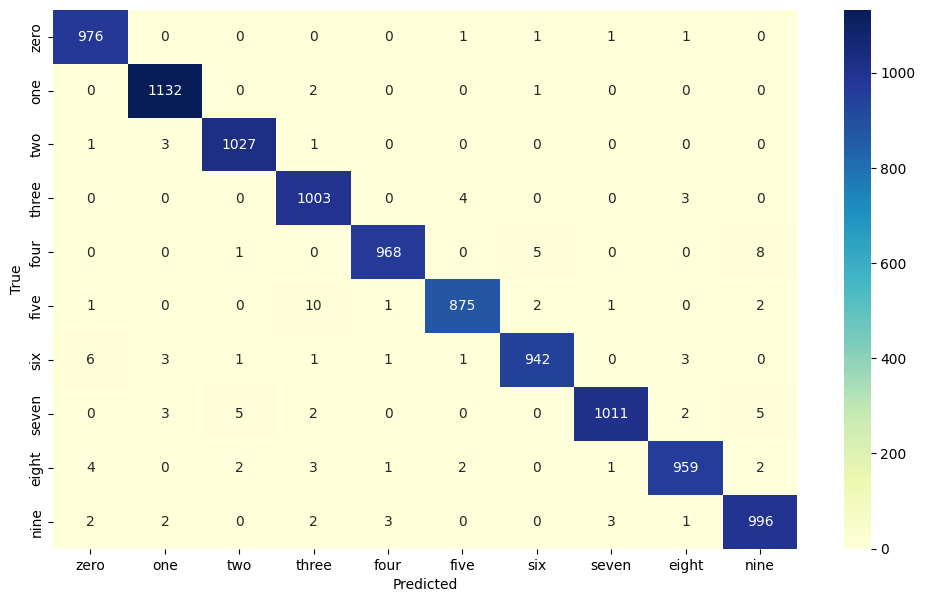

In [12]:
y_pred = []
y_true = []

for X, Y in test_dataloader:
    output = model(X) 
    
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) 
    
    Y = Y.data.cpu().numpy()
    y_true.extend(Y) 

        
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))

sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("True")
